In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import LSTM, Bidirectional, Conv2D, Dense, MaxPooling2D, Add,  Flatten, Input, Reshape, Embedding, Dropout, GlobalMaxPooling2D, ZeroPadding1D
from tensorflow.keras import Model
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pickle

In [5]:
with open("matched_captions.txt", "r") as f:
    image_captions = f.read()

image_captions = image_captions.split("\n")

In [6]:
image_captions_new = []

try:
    for i in image_captions:
        image_captions_new.append(f'<sos>{i.split(".jpg")[1].strip()}<eos>')
except Exception as e:
    print("there was an error:", e)

there was an error: list index out of range


In [11]:
vgg_model = VGG16(
    input_shape=(224,224,3),
    )

In [12]:
# encoder model
encoder_model = vgg_model.output
encoder_model = Model(vgg_model.input, vgg_model.layers[-2].output)
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
image_captions_new

In [19]:
images_path = os.path.join("D:\code\image_captioning","Images")
features = {}

for i in tqdm(os.listdir(images_path)):
    img_path = images_path + "/" + i
    image = load_img(img_path, target_size=(224,224))
    
    image = img_to_array(image)

    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    image = preprocess_input(image)
    feature = encoder_model.predict(image, verbose=0)

    image_id = i.split(".")[0]

    features[image_id] = feature

100%|██████████| 1000/1000 [02:19<00:00,  7.18it/s]


In [20]:


with open("features.pkl", "wb") as f:
    pickle.dump(features, f)

In [8]:
import pickle
with open("features.pkl", "rb") as f:
    features = pickle.load(f)


In [9]:
mapping = {}

for (image_id, feature), caption in zip(features.items(), image_captions_new):
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

In [24]:
features['2814037463_74de97da86'].shape

(1, 4096)

In [13]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
w2i = tokenizer.word_index
vocab_size = int(len(w2i)) + 1
vocab_size
max_length = max([len(i) for i in all_captions])

In [27]:
data_keys = []

for (image_id, feature), caption in zip(features.items(), image_captions_new):
    data_keys.append(image_id)

In [33]:
n_gram_sequences = []
output_captions = [] # Store the output captions (with EOS)
for caption in image_captions_new:
    seq = tokenizer.texts_to_sequences([caption])[0]
    n_grams = [seq[:i] for i in range(1, len(seq) + 1)] # Generate n-grams
    n_grams = pad_sequences(n_grams, maxlen=150, padding='post') 
    n_gram_sequences.append(n_grams)
    output_captions.append(seq) 

data_dict = {}
for image_id, feature, n_gram, output in zip(features.keys(),features.values() , n_gram_sequences, output_captions):
    data_dict[image_id] = {
        "feature_vector": feature,
        "n_gram_sequences": n_gram,
        "output_caption": to_categorical(output, num_classes=1500)  # Full caption as the output (with EOS)
    }

In [165]:
mapping['2814037463_74de97da86']

['<sos>woman has a finger pointing in her face .<eos>']

In [182]:
import pickle

pickle.dump(data_dict, open("data_dict.pkl", "wb"))

In [188]:
image_1_data = data_dict["282116218_7fd7583d6e"]

# Access "feature_vector" of "282116218_7fd7583d6e"
feature_vector = data_dict["282116218_7fd7583d6e"]["feature_vector"]

# Access "n_gram_sequences" of "282116218_7fd7583d6e"
n_gram_sequences = data_dict["282116218_7fd7583d6e"]["n_gram_sequences"]

# Access "output_caption" of "282116218_7fd7583d6e"
output_caption = data_dict["282116218_7fd7583d6e"]["output_caption"]

# Print them
print("Feature Vector:", feature_vector.shape)
print("N-Gram Sequences:", n_gram_sequences.shape)
print("Output Caption:", output_caption.shape)

Feature Vector: (1, 4096)
N-Gram Sequences: (16, 150)
Output Caption: (16, 1500)


In [47]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for key in data_keys:
            n += 1

            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)


            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y) 
                yield [X1, X2], y

                X1, X2, y = list(), list(), list()
                n = 0

In [48]:
import pickle
with open("image_features.pkl", "rb") as f:
    data_dict = pickle.load(f)

In [49]:
image_1_data = data_dict["2814037463_74de97da86"]
print(image_1_data["feature_vector"].shape)  
print(image_1_data["n_gram_sequences"].shape)  
print(image_1_data["output_caption"].shape) 

(10, 4096)
(10, 150)
(10, 1500)


In [35]:
data_dict

{'2814037463_74de97da86': {'feature_vector': array([[2.604207 , 2.723013 , 0.       , ..., 0.       , 0.       ,
          1.1700716]], dtype=float32),
  'n_gram_sequences': array([[ 2,  0,  0, ...,  0,  0,  0],
         [ 2, 30,  0, ...,  0,  0,  0],
         [ 2, 30, 99, ...,  0,  0,  0],
         ...,
         [ 2, 30, 99, ...,  0,  0,  0],
         [ 2, 30, 99, ...,  0,  0,  0],
         [ 2, 30, 99, ...,  0,  0,  0]]),
  'output_caption': array([[0., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)},
 '281419391_522557ce27': {'feature_vector': array([[0.       , 0.       , 0.       , ..., 3.9061942, 0.       ,
          0.       ]], dtype=float32),
  'n_gram_sequences': array([[  2,   0,   0, ...,   0,   0,   0],
         [  2,  13,   0, ...,   0,   0,   0],
         [  2,  13,

In [50]:
image_input = Input(shape=(4096, ))
image_caption = Dense(1026, activation='relu')(image_input)


caption_input = Input(shape=(150, ))
embedding = Embedding(vocab_size, 512, mask_zero=True)(caption_input)
lstm_layer = LSTM(1026)(embedding)

decoder_1 = tfl.add([image_caption,lstm_layer])
dense_1 = Dense(526, activation='relu')(decoder_1)
dense_2 = Dense(10, activation='relu')(dense_1)
output = Dense(vocab_size, activation='softmax')(dense_2)
# output = tf.squeeze(output, axis=0)
model = Model(inputs= [image_input, caption_input], outputs=output)
# image_caption.shape


In [51]:
print(model.inputs)
print(model.output)

[<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'input_4')>, <KerasTensor: shape=(None, 150) dtype=float32 (created by layer 'input_5')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 1500), dtype=tf.float32, name=None), name='dense_7/Softmax:0', description="created by layer 'dense_7'")


In [52]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 20
steps = len(data_keys) // batch_size

for i in range(epochs):
    generator = data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps)

In [ ]:
model.save('image_caption_model.h5')
model.save('image_caption_model.keras')
model.save_weights('image_caption_model.weights.h5')

In [53]:
for key, value in data_dict.items():
    print(f"Key: {key}")
    print(f"Feature Vector Length: {len(value['feature_vector'])}")
    print(f"N-Gram Sequences Length: {len(value['n_gram_sequences'])}")
    print(f"Output Caption Length: {len(value['output_caption'])}")
    print("--------------------")

Key: 2814037463_74de97da86
Feature Vector Length: 10
N-Gram Sequences Length: 10
Output Caption Length: 10
--------------------
Key: 281419391_522557ce27
Feature Vector Length: 12
N-Gram Sequences Length: 12
Output Caption Length: 12
--------------------
Key: 2814406547_a237ef0122
Feature Vector Length: 12
N-Gram Sequences Length: 12
Output Caption Length: 12
--------------------
Key: 2815256108_fc1302117d
Feature Vector Length: 13
N-Gram Sequences Length: 13
Output Caption Length: 13
--------------------
Key: 2815745115_c8479d560c
Feature Vector Length: 8
N-Gram Sequences Length: 8
Output Caption Length: 8
--------------------
Key: 2815755985_0fa55544c0
Feature Vector Length: 12
N-Gram Sequences Length: 12
Output Caption Length: 12
--------------------
Key: 2815788792_d226215d10
Feature Vector Length: 11
N-Gram Sequences Length: 11
Output Caption Length: 11
--------------------
Key: 2816259113_461f8dedb0
Feature Vector Length: 14
N-Gram Sequences Length: 14
Output Caption Length: 14
-

In [40]:
feature_vectors = []
n_gram_sequences = []
output_captions = []

for key, value in data_dict.items():
    feature_vectors.append(value['feature_vector'])
    n_gram_sequences.append(value['n_gram_sequences'])
    output_captions.append(value['output_caption'])

# Convert lists to numpy concatenates
feature_vectors = np.concatenate(feature_vectors)  # Shape: (num_samples, 4096)
n_gram_sequences = np.concatenate(n_gram_sequences)  # Shape: (num_samples, sequence_length)
output_captions = np.concatenate(output_captions)  # Shape: (num_samples, caption_length)

# Create the TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(((feature_vectors, n_gram_sequences), output_captions))

# Example: Batch the dataset
dataset = dataset.batch(32)

# Iterate through the dataset to check the shapes of the batches
for (feature_batch, n_gram_batch), caption_batch in dataset:
    print("Feature batch shape:", feature_batch.shape)
    print("N-gram batch shape:", n_gram_batch.shape)
    print("Caption batch shape:", caption_batch.shape)

ValueError: Dimensions 1000 and 12131 are not compatible

In [173]:
for (feature_batch, n_gram_batch), caption_batch in dataset.take(1):
    print(feature_batch.shape, n_gram_batch.shape, caption_batch.shape)

(32, 4096) (32, 150) (32, 1500)


In [174]:
image_ids = list(mapping.keys())

In [11]:
def idx_to_wrd(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [12]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'sos'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = model.predict([image, sequence], verbose=0)
        predicted_index = np.argmax(prediction)
        word = idx_to_wrd(predicted_index, tokenizer)

        if word is None:
            break
            
        in_text += " " + word

        if word == 'eos':
            break
    
    return in_text

In [3]:
model_new = tf.keras.models.load_model("image_caption_model.h5")
model_new.load_weights("image_caption_model.weights.h5")

['<sos>beige and white dog is running quickly across the grass .<eos>']
sos black white white dog running is running eos


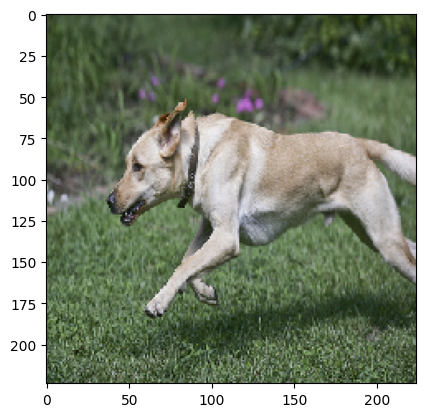

In [20]:
image_name = "2833560457_24aedf3bef.jpg"
image_id = image_name.split(".")[0]
print(mapping[image_id])

image_name = os.path.join("D:\code\image_captioning\Images", "2833560457_24aedf3bef.jpg")

image = load_img(image_name, target_size=(224,224))  
image = img_to_array(image)
image = image /255.0

plt.imshow(image)

y_pred = predict_caption(model_new, features[image_id], tokenizer, 150)
print(y_pred)

['<sos>man in a blue shirt passes under the Samsung arch .<eos>']
sos man in a shirt shirt is shirt a wall eos


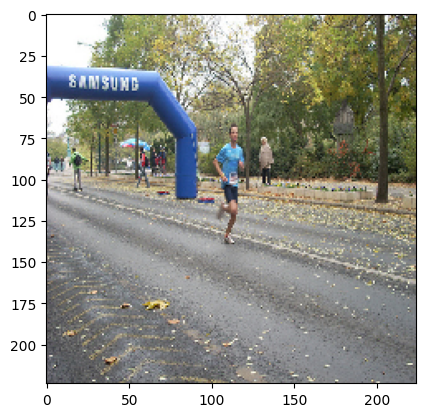

In [21]:
image_name = "3085357792_efcf297c71.jpg"
image_id = image_name.split(".")[0]
print(mapping[image_id])

image_name = os.path.join("D:\code\image_captioning\Images", "3085357792_efcf297c71.jpg")

image = load_img(image_name, target_size=(224,224))  
image = img_to_array(image)
image = image /255.0

plt.imshow(image)

y_pred = predict_caption(model_new, features[image_id], tokenizer, 150)
print(y_pred)

sos surfboarder is doing a surfboard on a white surfboard eos


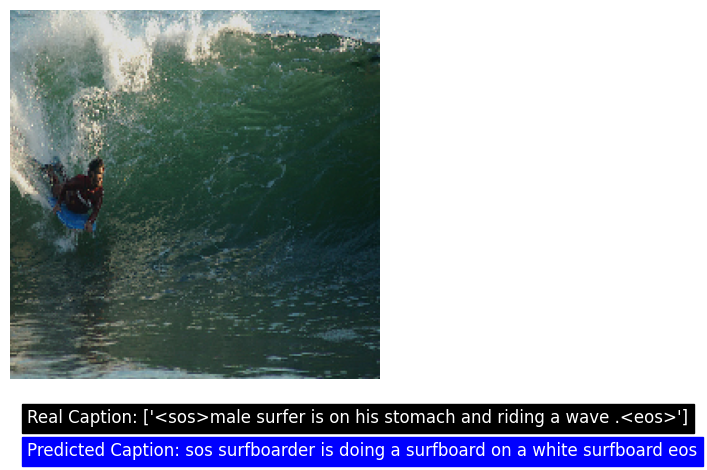

In [42]:
image_name = "3029463004_c2d2c8f404.jpg"
image_id = image_name.split(".")[0]
# print(mapping[image_id])

image_name = os.path.join(r"D:\code\New folder\Images", "3029463004_c2d2c8f404.jpg")

image = load_img(image_name, target_size=(224,224))  
image = img_to_array(image)
image = image /255.0


y_pred = predict_caption(model_new, features[image_id], tokenizer, 150)
print(y_pred)

plt.imshow(image)

plt.axis("off")  # Turn off the axes for a cleaner look

# Add two texts to the image
plt.text(10, 250, f"Real Caption: {mapping[image_id]}", color="white", fontsize=12, backgroundcolor="black")
plt.text(10, 270, f"Predicted Caption: {y_pred}", color="white", fontsize=12, backgroundcolor="blue")

# Show the plot
plt.show()